In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [115]:
df_append = pd.DataFrame()
i = 1
for filename in listdir("dataset\\dataset\\train\\boxes_transcripts_labels\\"):
# for filename in listdir("dataset\\dataset\\train\\New\\"):
    df_temp = pd.read_csv("dataset\\dataset\\train\\boxes_transcripts_labels\\" + filename, sep = ",", header = None)
    df_temp.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript','field']
    df_temp_trimmed = df_temp.loc[df_temp['field'] != 'OTHER']
    df_temp_trimmed.insert(0, 'File No.', i)
    i = i + 1
    df_append = pd.concat([df_append, df_temp_trimmed], ignore_index = True)

#Lets copy our data before any analysis
df = df_append.copy()

df_append['x_center'] = df_append[['x_top_left', 'x_bottom_right']].mean(axis=1)
df_append['y_center'] = df_append[['y_top_left', 'y_bottom_right']].mean(axis=1)
df_append['index_len'] = df_append['end_index'] - df_append['start_index']

# df_append.drop(['x_top_left', 'y_top_left','x_bottom_right','y_bottom_right'], axis=1)
# df_append = df_append[['File No.','start_index', 'end_index', 'x_center', 'y_center','field']]

#df_append.columns = ['start_index', 'end_index', 'x_top_left', 'y_top_left', 'x_bottom_right', 'y_bottom_right','transcript','field']

encoder = ce.ordinal.OrdinalEncoder()
df_append['field'] = encoder.fit_transform(df_append['field'])

df_append = df_append.drop(['transcript'], axis = 1)


<Axes: >

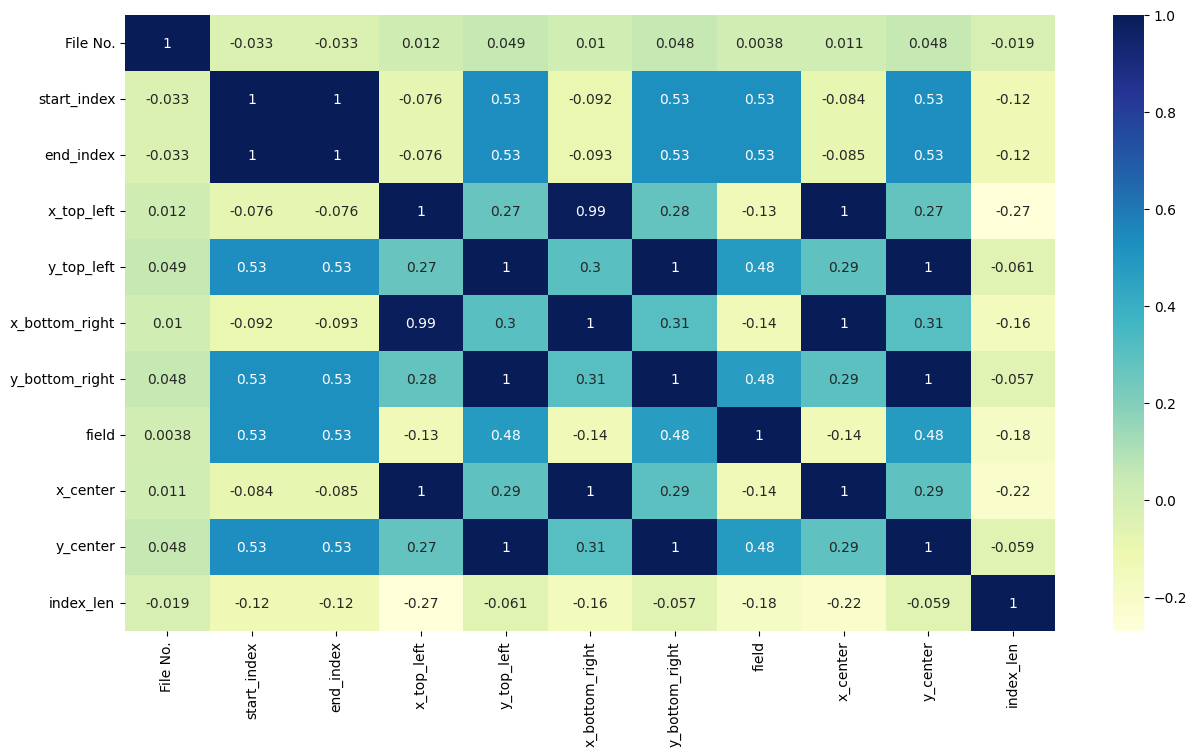

In [116]:
corrM = df_append.corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corrM, annot=True, cmap="YlGnBu")

In [117]:
# x_center and y_center are able to include the relation that the x and y coordinates of top left and bottom right points have.
# So, it is safe to replace the 4 columns with their centres.
# And we drop the file No as well
df_append = df_append.drop(['x_top_left','x_bottom_right','y_top_left','y_bottom_right'], axis = 1)

# The highest correlation with field is with start and end indices. And the highest anti correlation is of index length.

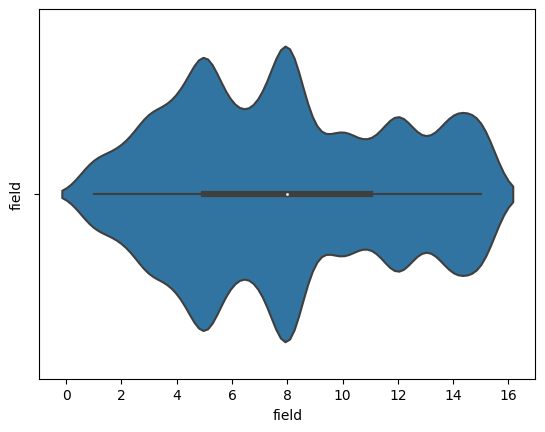

In [118]:
plt.ylabel('field')
# sns.boxplot(x=df_append['index_len'])
sns.violinplot(x=df_append['field'])
plt.show()

# All features have outliers except for field. Possibly due to rotated images?

array([[<Axes: title={'center': 'File No.'}>,
        <Axes: title={'center': 'start_index'}>,
        <Axes: title={'center': 'end_index'}>],
       [<Axes: title={'center': 'field'}>,
        <Axes: title={'center': 'x_center'}>,
        <Axes: title={'center': 'y_center'}>],
       [<Axes: title={'center': 'index_len'}>, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

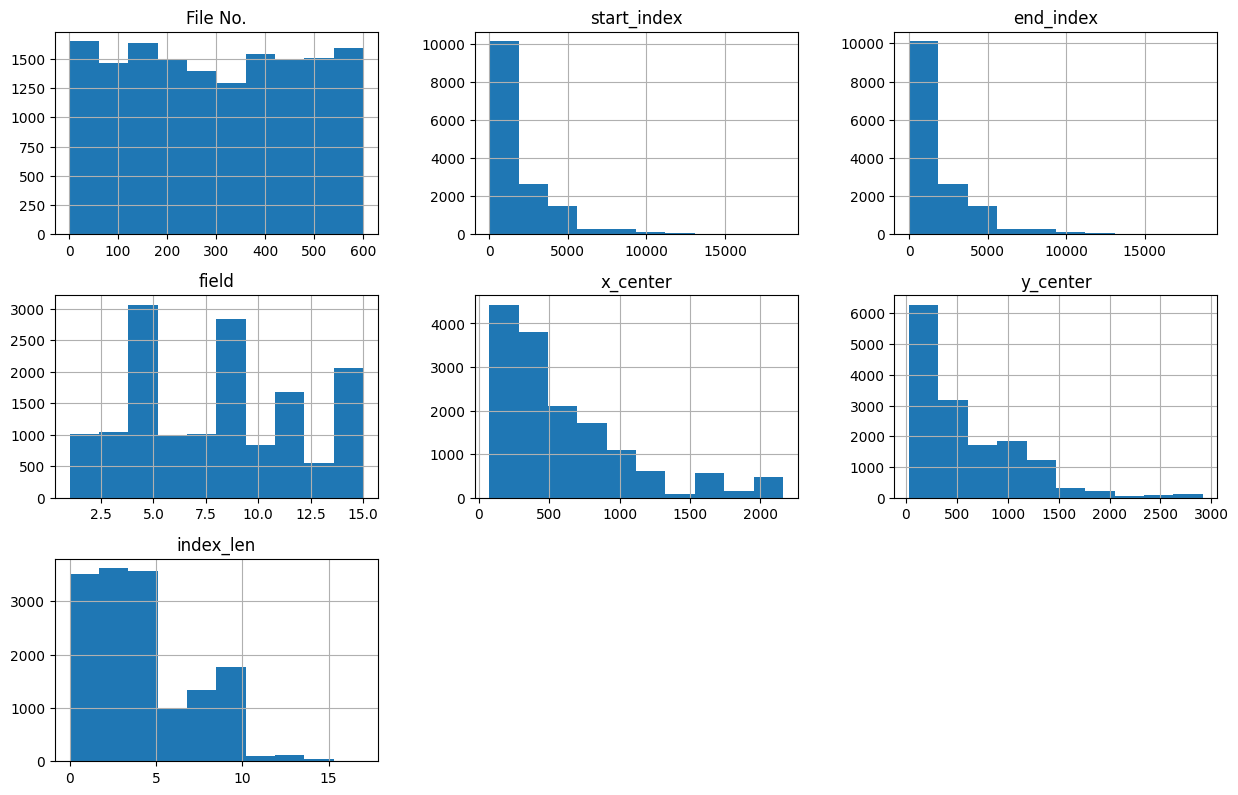

In [119]:
df_append.hist(figsize=(15,30),layout=(9,3))

field
8     2260
5     1954
12    1123
4     1106
3     1043
14    1043
15    1023
7     1009
6      979
10     840
9      572
11     552
13     546
2      542
1      476
Name: count, dtype: int64


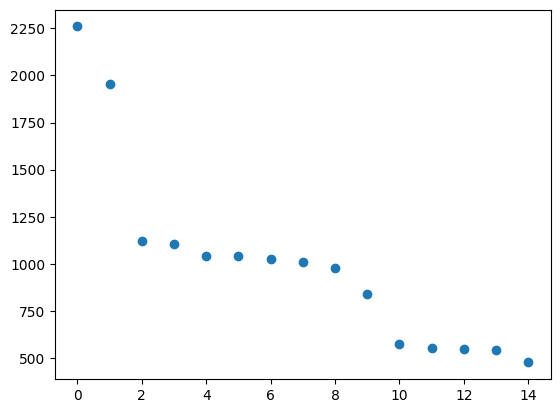

In [120]:
df1 = df_append['field'].value_counts()
print(df1)
plt.scatter(range(15),df1)

# Since, there is only one data of each kind per file. THe count difference is due to the fact that some labels are broken into multiple tokens. Ex: Address

In [121]:
# Check for negatives.
print('Negatives: ' + str(np.any(df_append<0)))
df_append.head()

Negatives: False


,File No.,start_index,end_index,field,x_center,y_center,index_len
0,1,210,220,1,390.0,35.5,10
1,1,470,479,2,137.5,89.0,9
2,1,557,562,3,765.5,88.5,5
3,1,564,565,3,822.0,89.0,1
4,1,591,598,4,1041.5,89.0,7


In [122]:
y = df_append[['field']]
X = df_append[['File No.', 'start_index', 'end_index', 'x_center', 'y_center', 'index_len']]
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
cv_splits = list(cv.split(X,y))

estimator = RandomForestClassifier(random_state = 2)
Rfecv = RFECV(estimator = estimator, cv = cv)
Rfecv.fit(X,y.values.ravel())

selected_features = []

for i, feature in enumerate(X.columns):
    if Rfecv.support_[i]:
        selected_features.append(feature)

print(f'{len(selected_features)} features selected out of {len(X.columns)}.')
print(f'\nSelected Features: \n')
for feature in selected_features:
    print(feature)

5 features selected out of 6.

Selected Features: 

start_index
end_index
x_center
y_center
index_len
